# Custormer Churn Prediction
Predict customer churn based on customer data - usage behaviour and demographics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn

In [2]:
# Load dataset
df = pd.read_csv('./Churn_Modelling.csv')
df = df.dropna() # Remove missing records

print("Dataset size:", df.size)

Dataset size: 140000


In [3]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

## Data Visualization

   Exited
0    7963
1    2037


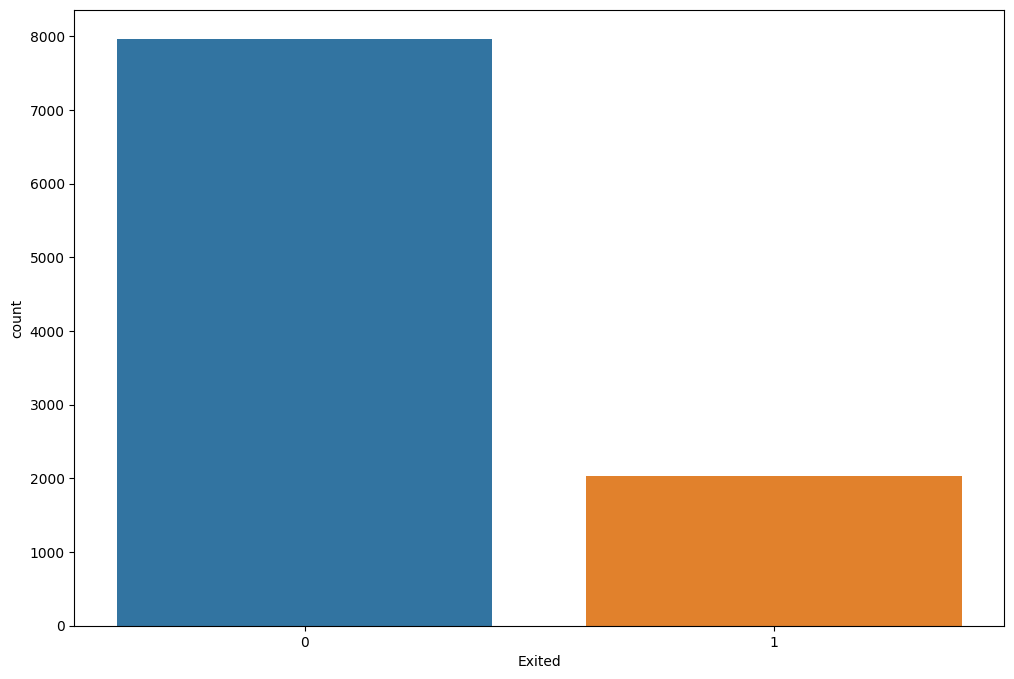

In [4]:
plt.figure(figsize=(12, 8))
sns.countplot(df, x="Exited")
plt.plot()

print(df['Exited'].value_counts().to_frame())

[]

<Figure size 1200x800 with 0 Axes>

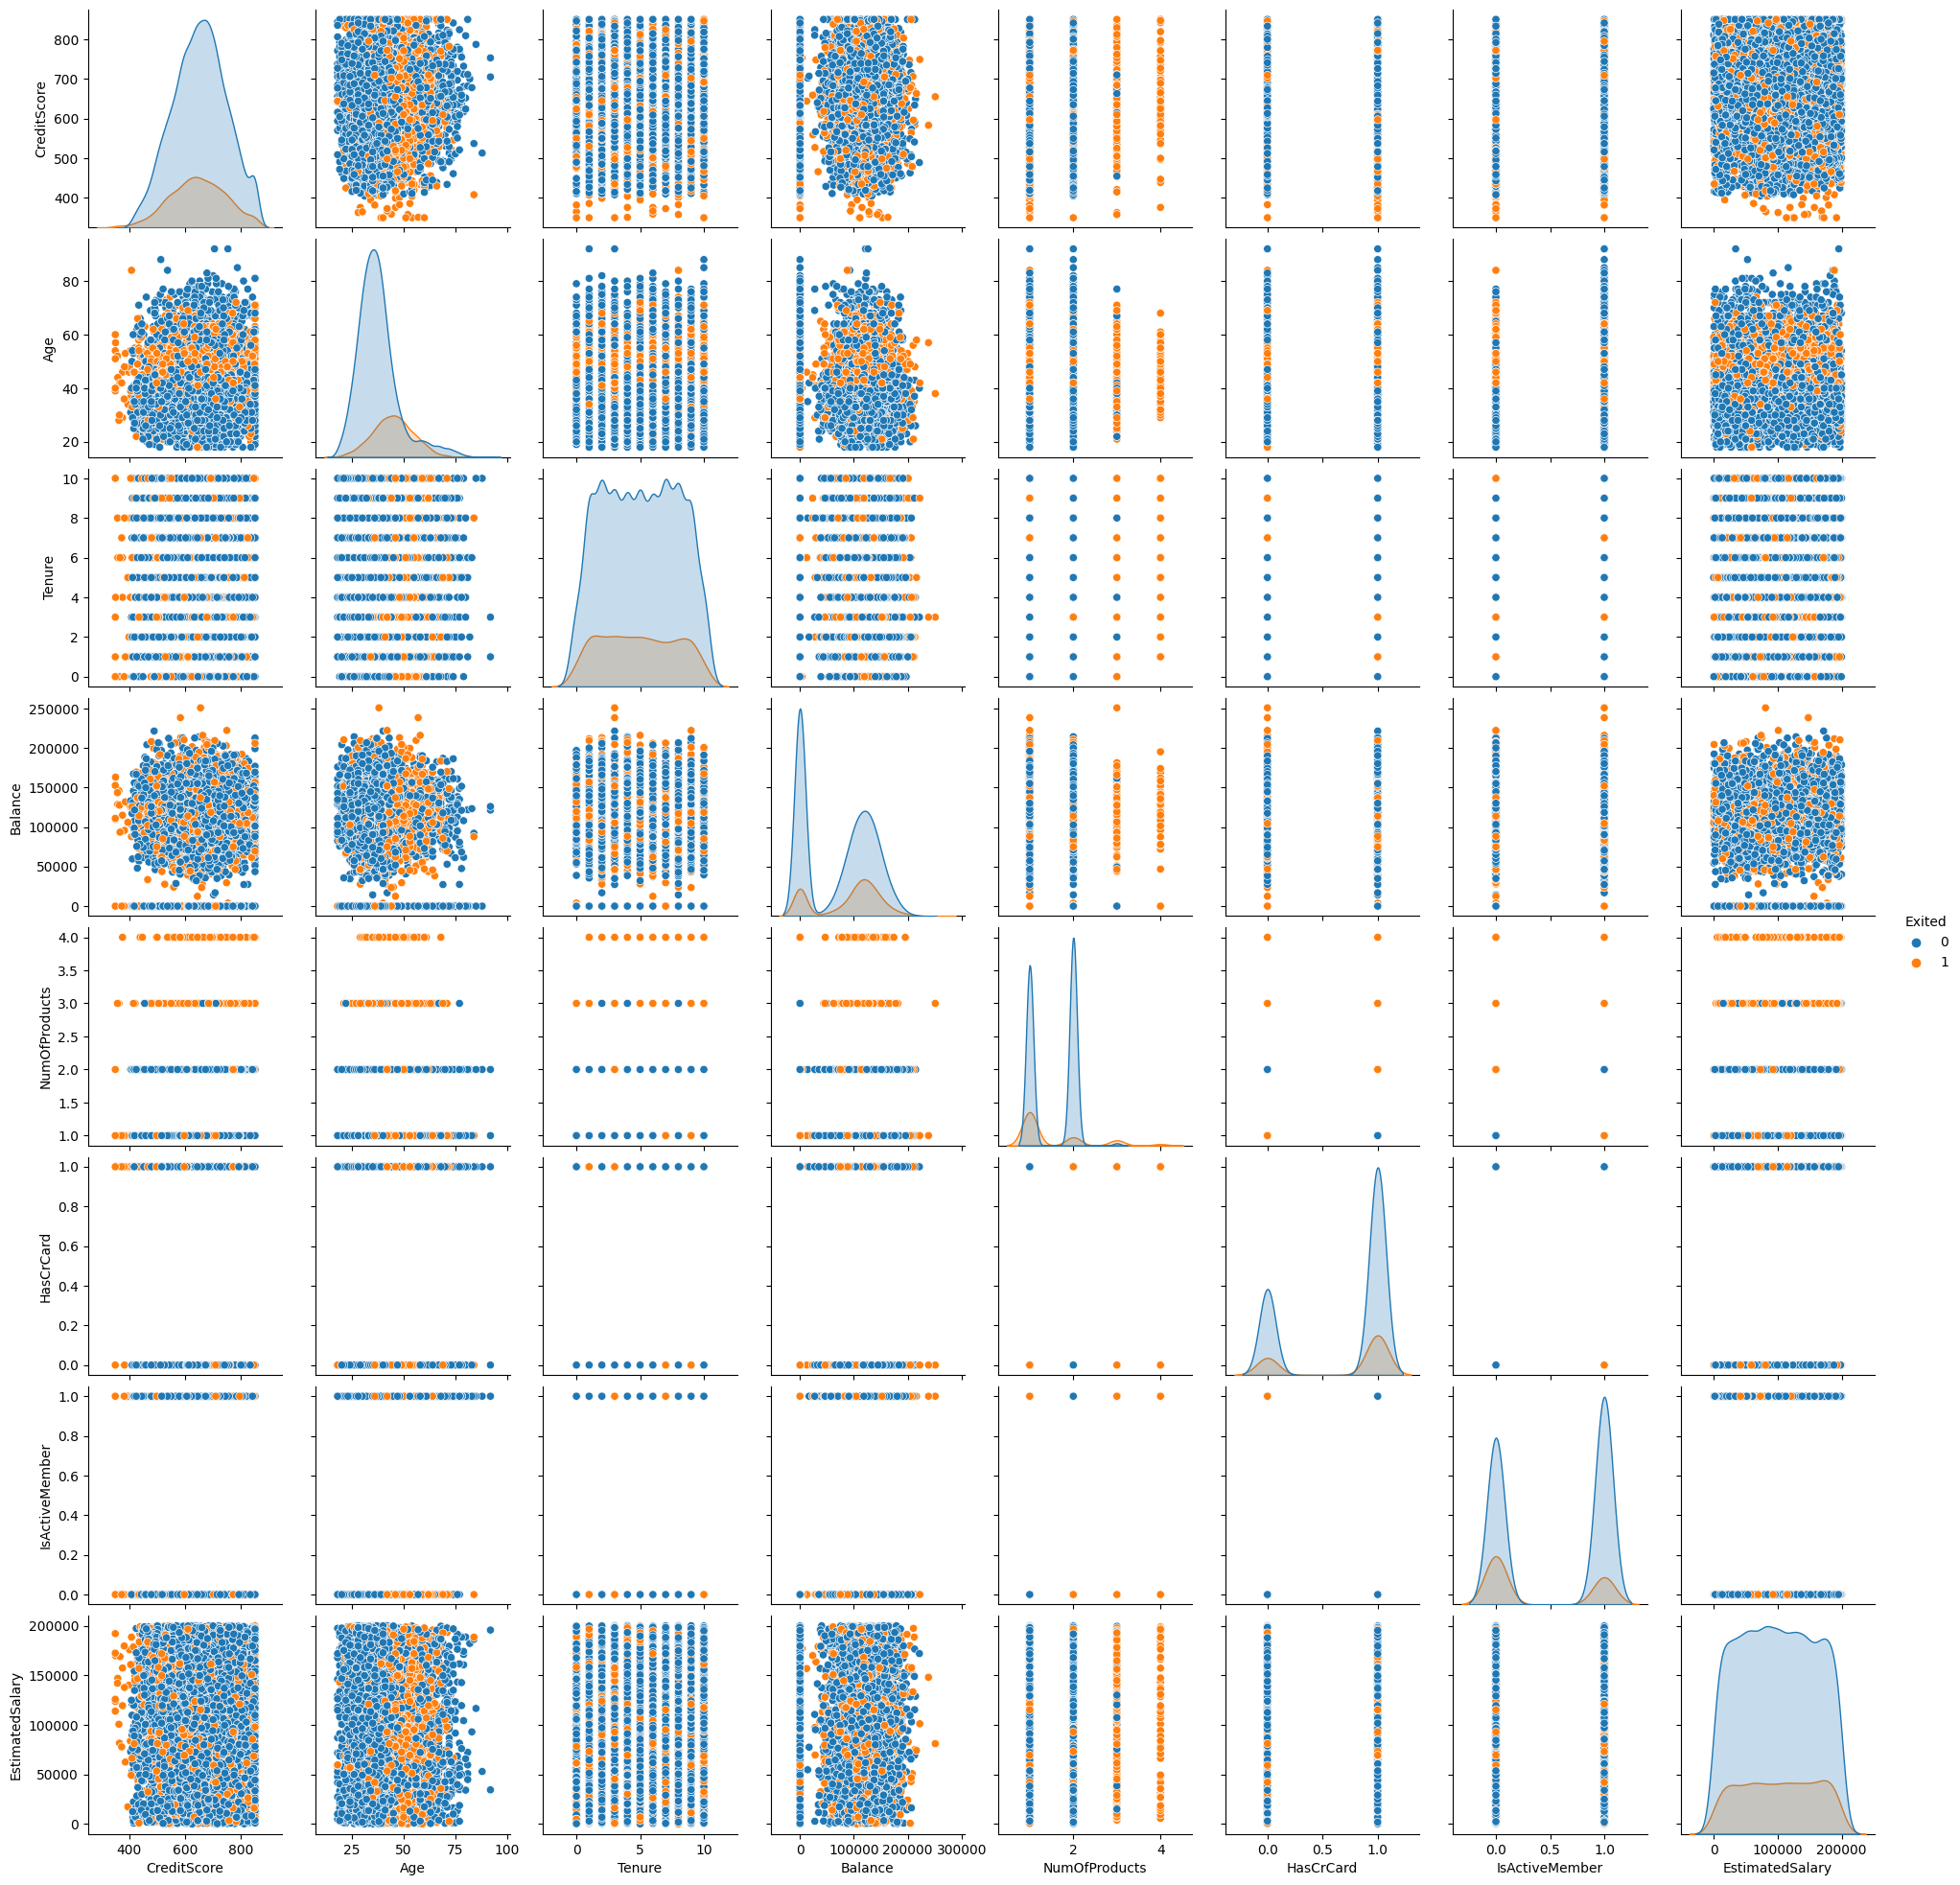

In [5]:
# Visualize non-categorical variables
plt.figure(figsize=(12, 8))
sns.pairplot(data=df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1), hue="Exited")
plt.plot()

[]

<Figure size 1200x800 with 0 Axes>

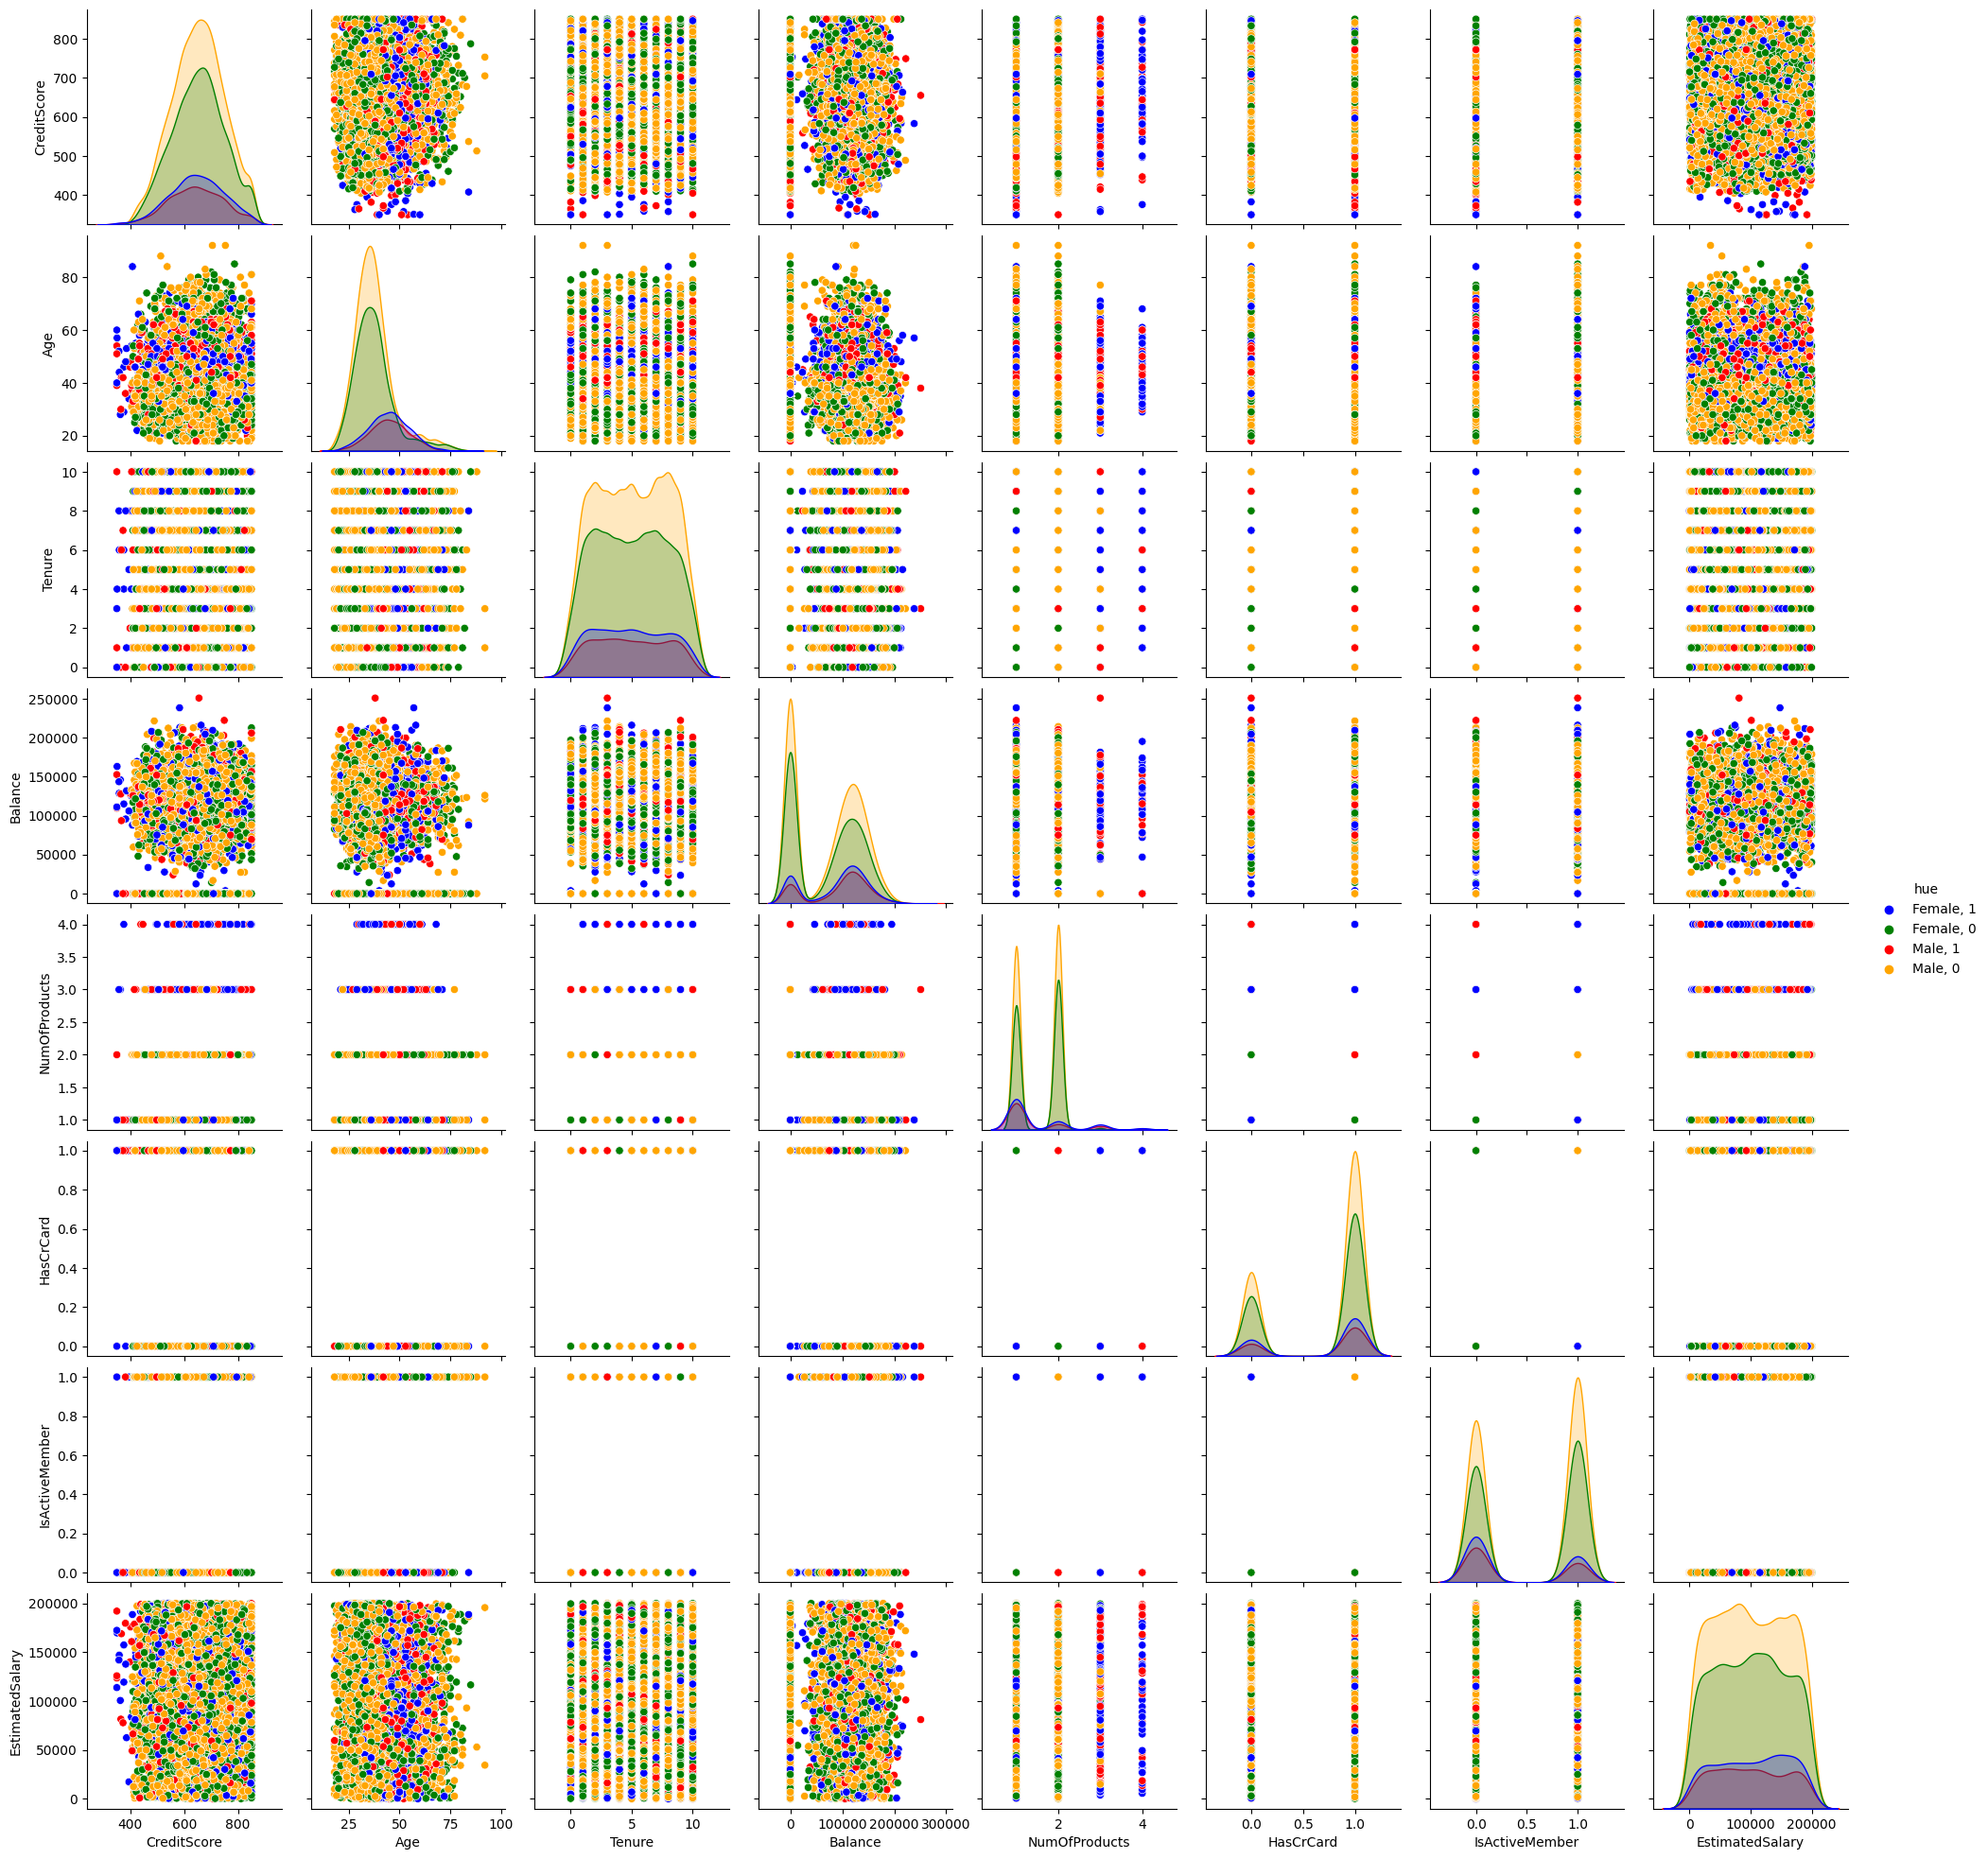

In [6]:
# Visualize non-categorical variables (Gender and Exit status)
df_temp = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_temp['hue'] = df_temp['Gender'].astype(str) + ', ' + df_temp['Exited'].astype(str)
plt.figure(figsize=(12, 8))
sns.pairplot(data=df_temp.drop(['Exited'], axis=1), hue='hue', palette=["Blue", "Green", "Red", "Orange"])
plt.plot()

In [7]:
# Removing unwanted columns, and separating into data and labels
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

# One-hot encoding - categorical variables
X = pd.get_dummies(X, columns=['Geography', 'Gender'])

# Splitting data into training and test sets (80-20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
X.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1        101348.88                 1                  0   
1               1        112542.58                 0                  0   
2               0        113931.57                 1                  0   
3               0         93826.63                 1                  0   
4               1         79084.10                 0                  0   

   Geography_Spain  Gender_Female  Gender_Male  
0                0              1            0  
1                1              1            0  
2                0              1            0  
3                0              1            0  
4                1              1            0

   Exited
0    6377
1    1623


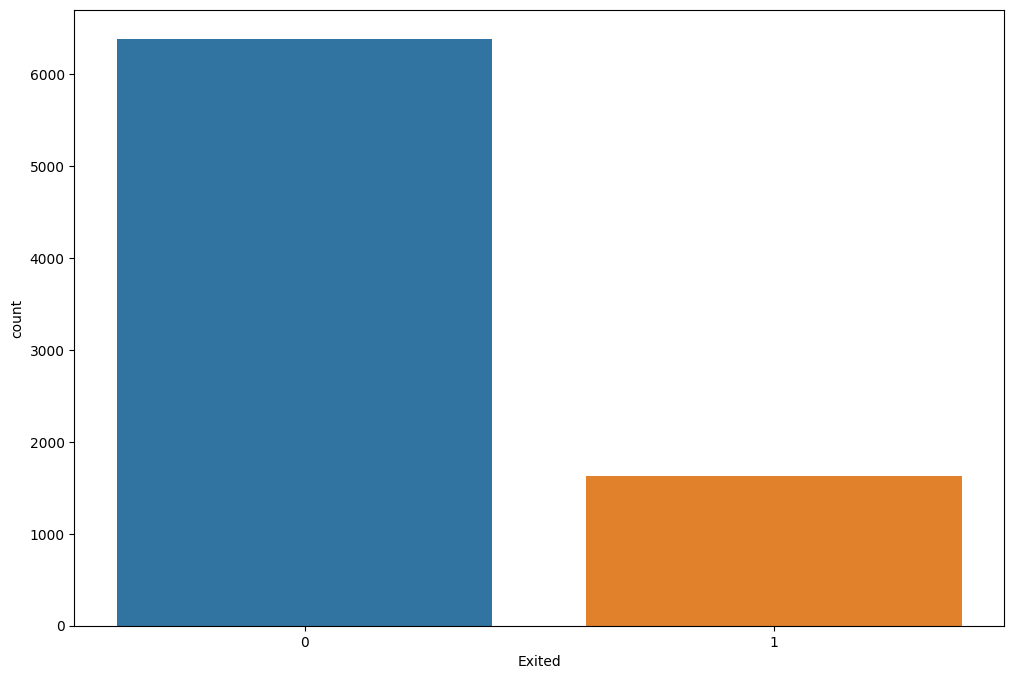

In [9]:
plt.figure(figsize=(12, 8))
sns.countplot(y_train.to_frame(), x="Exited")
plt.plot()

print(y_train.value_counts().to_frame())

In [10]:
# Oversampling to deal with imbalance
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 6377), (1, 6377)]


   Exited
0    6377
1    1623


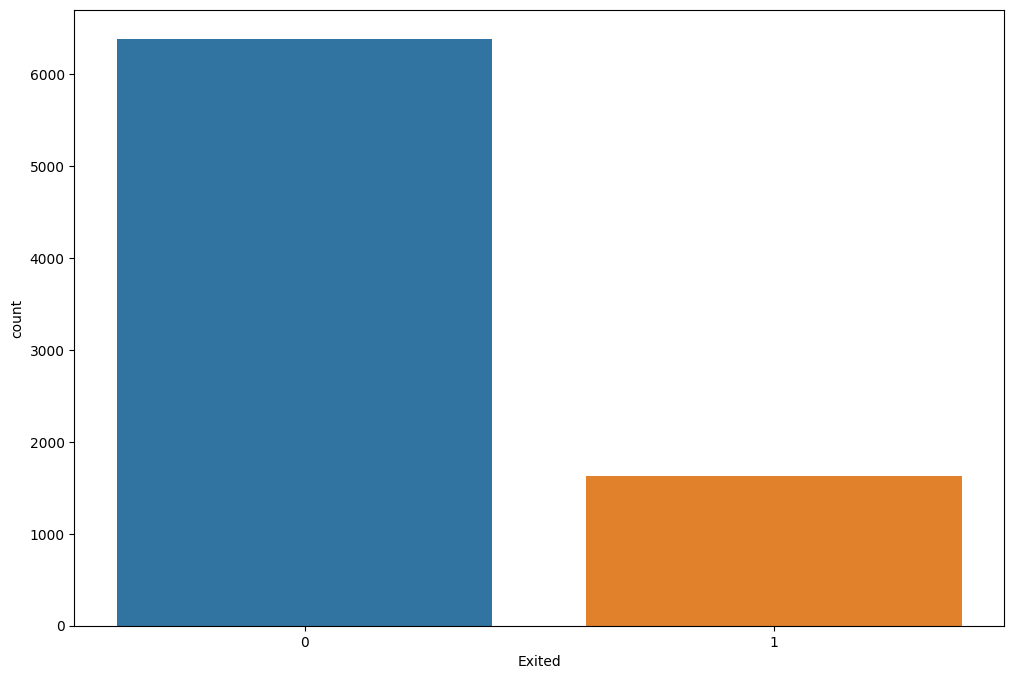

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(y_train.to_frame(), x="Exited")
plt.plot()

print(y_train.value_counts().to_frame())

In [12]:
X_train, y_train = X_train_resampled, y_train_resampled

In [13]:
# Normalizing dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[]

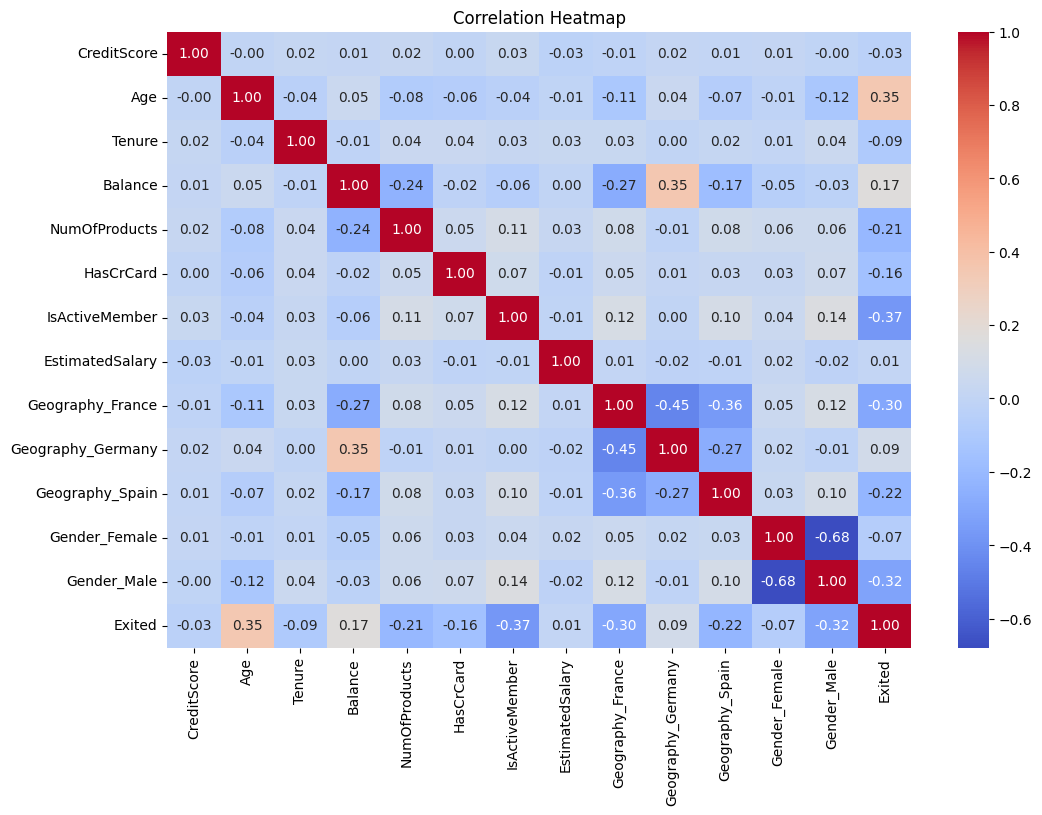

In [14]:
# Correlation
correlation_data = pd.concat([X_train_scaled, y_train], axis=1)
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.plot()

## Model selection (Baseline)
### Logistic Regression

In [15]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression(random_state=123)
lrmodel.fit(X_train_scaled, y_train)

LogisticRegression(random_state=123)

In [16]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = lrmodel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.7990
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1586
           1       0.52      0.40      0.45       414

    accuracy                           0.80      2000
   macro avg       0.69      0.65      0.67      2000
weighted avg       0.78      0.80      0.79      2000



### Random Forest

In [17]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier(n_estimators=100, random_state=123)
rfmodel.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=123)

In [18]:
y_pred = rfmodel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8475
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      1586
           1       0.65      0.56      0.60       414

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000



### XG boost

In [19]:
# XGboost
xgbModel = xgb.XGBClassifier(objective='binary:logistic', seed=123)
xgbModel.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123, ...)

In [20]:
y_pred = xgbModel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8455
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1586
           1       0.64      0.57      0.61       414

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000



##  Selecting Random Forest - Hyperparamter tuning and evaluation

In [21]:
# Grid Search - Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfModel = RandomForestClassifier(n_estimators=100, random_state=123)
grid_search = GridSearchCV(estimator=rfModel, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8876469819601693


In [22]:
# Final model
rfModel = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=123)
rfModel.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, random_state=123)

In [23]:
y_pred = rfModel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8435
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1586
           1       0.64      0.56      0.60       414

    accuracy                           0.84      2000
   macro avg       0.76      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000



## Feature Importance

Top 10 Features:
             feature  importance
1                Age    0.194503
3            Balance    0.101822
7    EstimatedSalary    0.095526
6     IsActiveMember    0.091844
4      NumOfProducts    0.090710
0        CreditScore    0.087670
12       Gender_Male    0.064312
8   Geography_France    0.062477
11     Gender_Female    0.058724
2             Tenure    0.057512


[]

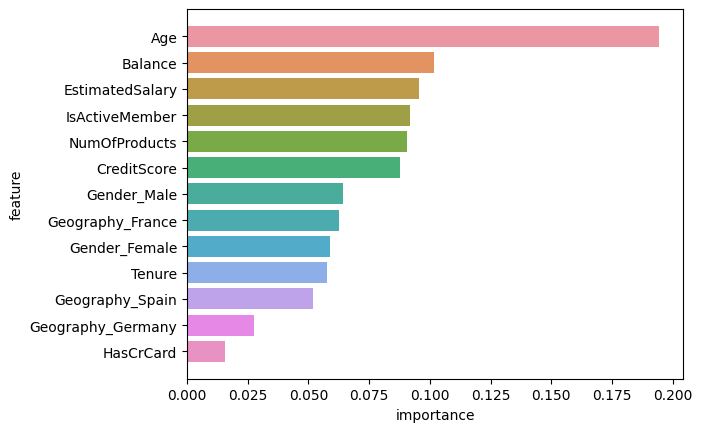

In [24]:
# Feature importance
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': rfModel.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Print the top N important features
top_n = 10
print(f"Top {top_n} Features:")
print(feature_importance_df.head(top_n))

sns.barplot(feature_importance_df, x="importance", y="feature")
plt.plot()